In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os
import json
import sys
import shutil
from pathlib import Path
from collections import defaultdict, Counter 
import warnings
warnings.filterwarnings('ignore')

In [77]:
# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

[Dataset source](https://doi.org/10.1038/s41597-024-03656-8)

In [78]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)


In [79]:
YOLO_IN = Path("../raw_data/Data_YOLO")
YOLO_OUT = Path("../data_eda")

# Unsplit copy for EDA (created from the pre-split dataset)
if YOLO_OUT.exists() and any(YOLO_OUT.iterdir()):
    print(f"already exists at {YOLO_OUT}, skipping")
else:    
    for split in ["train", "val", "test"]:
        img_dir = YOLO_IN / "images" / split
        for f in img_dir.glob("*.[jp][pn]g"):
            shutil.copy2(f, YOLO_OUT / "images" / f.name)
            lbl = YOLO_IN / "labels" / split / (f.stem + ".txt")
            if lbl.exists():
                shutil.copy2(lbl, YOLO_OUT / "labels" / lbl.name)
        print(f"YOLO: merged to {YOLO_OUT}")

already exists at ..\data_eda, skipping


In [80]:
IMAGES_DIR = Path("../data_eda/images")
LABELS_DIR = Path("../data_eda/labels")

# Count total files
img_count = len([f for f in os.listdir(IMAGES_DIR) if f.endswith(('.jpg', '.png'))])
lbl_count = len([f for f in os.listdir(LABELS_DIR) if f.endswith('.txt')])

print(f"\nTotal Images: {img_count} files")
print(f"Total Labels: {lbl_count} files")



Total Images: 10259 files
Total Labels: 10259 files


In [81]:
# Class names for PCB defects taken from paper section Methods/Defect labeling and dataset partition
CLASS_NAMES = {
    0: "SH",      # Short
    1: "SP",      # Spur
    2: "SC",      # Spurious Copper
    3: "OP",      # Open 
    4: "MB",      # Mouse Bite
    5: "HB",      # Hole Breakout
    6: "CS",      # Conductor Scratch
    7: "CFO",     # Conductor Foreign Object
    8: "BMFO"     # Base Material Foreign Object
}

## Dataset Structure & YOLO Format

### EDA Data Organization 
The original dataset is pre-split into train/val, but we merge it and analyze the full set here as we will resplit ourselves later beefore training.

Each label file (`.txt`) contains one line per defect with the format:
```
class_id center_x center_y width height
```

**All coordinates are normalized (0-1) relative to image dimensions:**
- `class_id`: Integer representing defect type (0-8)
- `center_x`: X-coordinate of bounding box center (0 = left edge, 1 = right edge)
- `center_y`: Y-coordinate of bounding box center (0 = top edge, 1 = bottom edge)
- `width`: Bounding box width as fraction of image width
- `height`: Bounding box height as fraction of image height

**Example:**
```
1 0.6283 0.5155 0.4779 0.0752
```
This represents a defect of class 1 (SP - Spur) with its center at (62.83%, 51.55%) of the image, spanning 47.79% width and 7.52% height.


In [82]:
def parse_yolo_labels(labels_dir):
    """
    Parse YOLO format labels and extract statistics.
    YOLO format: class_id center_x center_y width height (all normalized 0-1)
    """
    annotations = []
    
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
            
        label_path = os.path.join(labels_dir, label_file)
        
        with open(label_path, 'r') as f:
            lines = f.readlines()
            
        for line in lines:
            if line.strip():
                parts = line.strip().split()
                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                annotations.append({
                    'filename': label_file.replace('.txt', '.jpg'),
                    'class_id': class_id,
                    'class_name': CLASS_NAMES.get(class_id, f"class_{class_id}"),
                    'center_x': center_x,
                    'center_y': center_y,
                    'bbox_width': width,
                    'bbox_height': height,
                    'bbox_area': width * height
                })
    
    return pd.DataFrame(annotations)


In [83]:
all_annotations = parse_yolo_labels(LABELS_DIR)

print(f"\n Total: {len(all_annotations)} annotations from {len(all_annotations['filename'].unique())} images")
print(f"\nDataset Overview:")
print(all_annotations.head())



 Total: 20276 annotations from 10259 images

Dataset Overview:
      filename  class_id class_name  center_x  center_y  bbox_width  \
0  0003730.jpg         1         SP    0.6283    0.5155      0.4779   
1  0003730.jpg         1         SP    0.3363    0.5376      0.1416   
2  0003759.jpg         0         SH    0.5664    0.4912      0.1327   
3  0003759.jpg         5         HB    0.4646    0.5752      0.1858   
4  0004469.jpg         1         SP    0.4248    0.5022      0.2655   

   bbox_height  bbox_area  
0       0.0752   0.035938  
1       0.0398   0.005636  
2       0.1327   0.017609  
3       0.1858   0.034522  
4       0.1106   0.029364  


# Examples visualization

In [84]:
def draw_yolo_boxes(image_path, label_path, class_names):
    """
    Draw bounding boxes on image from YOLO format labels
    """
    # Read image
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Read labels
    if not os.path.exists(label_path):
        return img
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Define colors for each class (RGB)
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255),
        (255, 255, 0), (255, 0, 255), (0, 255, 255)
    ]
    
    for line in lines:
        if line.strip():
            parts = line.strip().split()
            class_id = int(parts[0])
            center_x = float(parts[1]) * w
            center_y = float(parts[2]) * h
            bbox_w = float(parts[3]) * w
            bbox_h = float(parts[4]) * h
            
            # Convert to corner coordinates
            x1 = int(center_x - bbox_w / 2)
            y1 = int(center_y - bbox_h / 2)
            x2 = int(center_x + bbox_w / 2)
            y2 = int(center_y + bbox_h / 2)
            
            # Draw rectangle
            color = colors[class_id % len(colors)]
            cv.rectangle(img, (x1, y1), (x2, y2), color, 2)
            
            # Draw label
            label = class_names.get(class_id, f"Class {class_id}")
            cv.putText(img, label, (x1, y1-10), cv.FONT_HERSHEY_SIMPLEX, 
                      0.5, color, 2)
    
    return img


### Visualize sample images with annotations

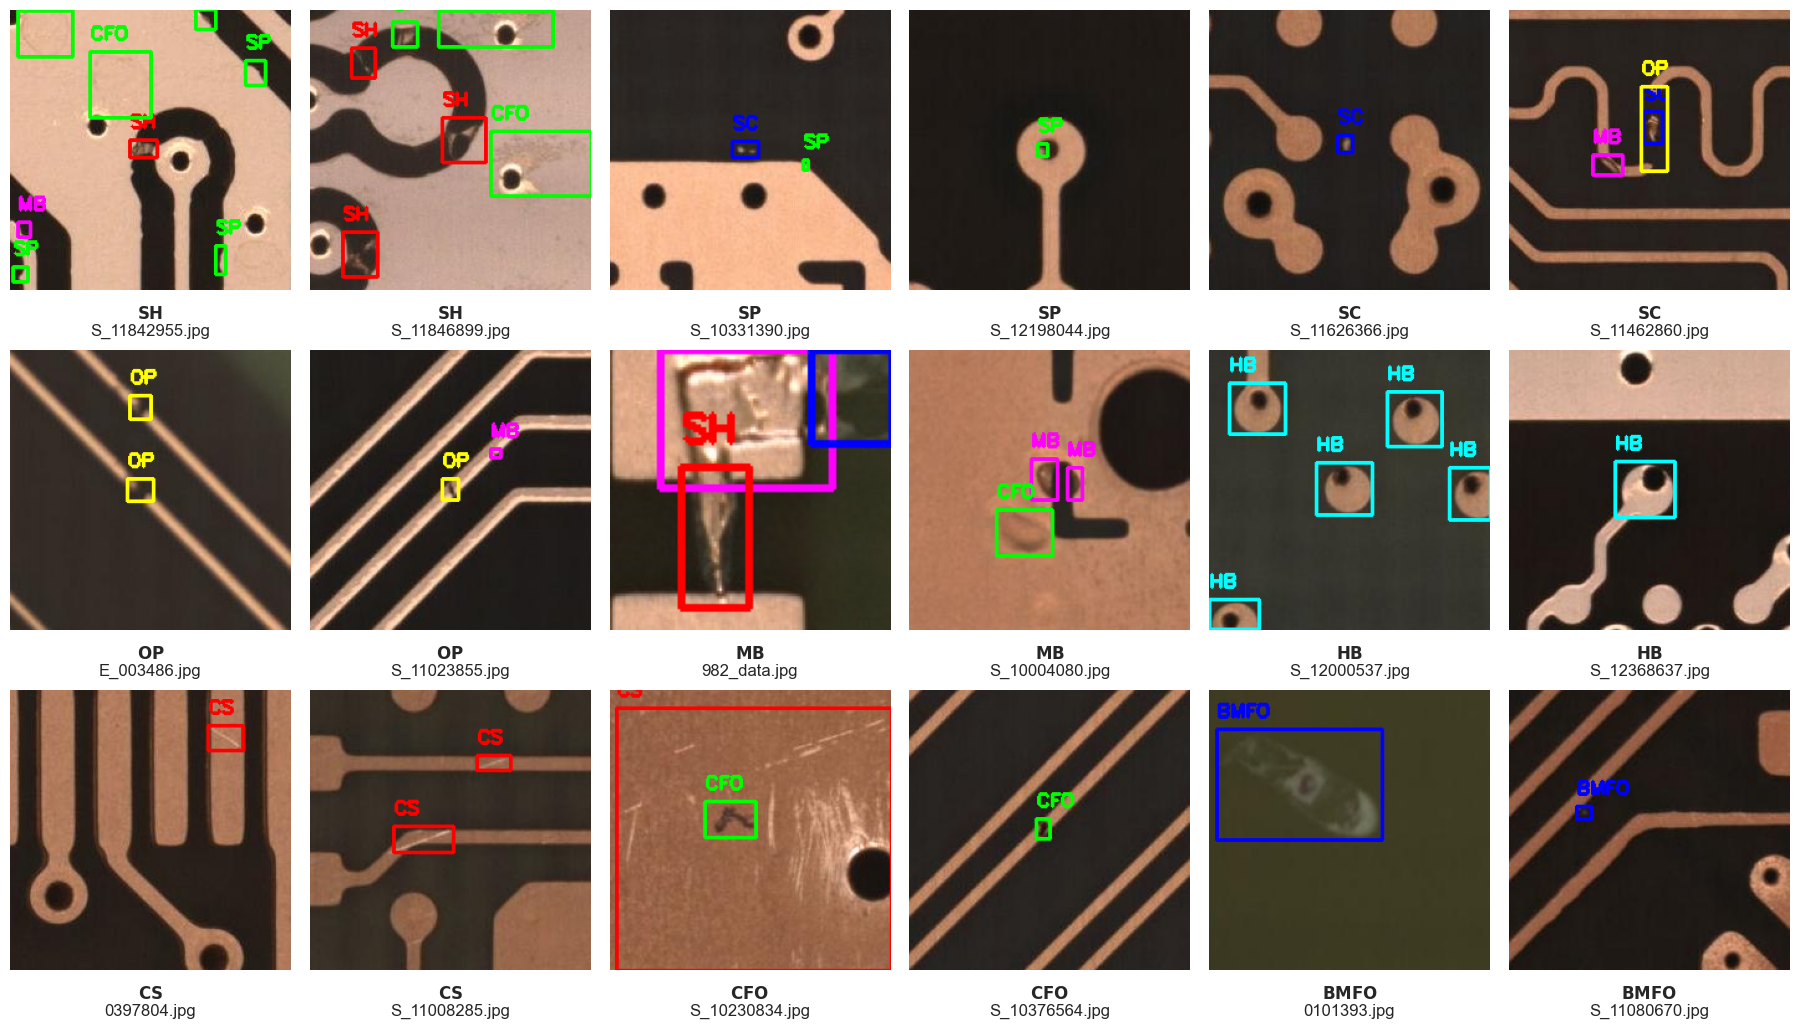

In [85]:
# Sample images from each class - reorganized layout (3 rows × 6 cols)
samples_per_class = 2
classes_per_row = 3
total_cols = classes_per_row * samples_per_class  # 3 classes × 2 samples = 6 columns
total_rows = int(np.ceil(len(CLASS_NAMES) / classes_per_row))  # 9 classes / 3 = 3 rows

fig, axes = plt.subplots(total_rows, total_cols, figsize=(18, 10))

class_items = list(CLASS_NAMES.items())

for idx, (class_id, class_name) in enumerate(class_items):
    # Calculate position in grid
    row_idx = idx // classes_per_row  # Which row (0, 1, or 2)
    class_in_row = idx % classes_per_row  # Position within row (0, 1, or 2)
    col_start = class_in_row * samples_per_class  # Starting column for this class
    
    # Get samples for this class
    class_samples_df = all_annotations[all_annotations['class_id'] == class_id][['filename']].drop_duplicates()
    
    if len(class_samples_df) > 0:
        # Take up to samples_per_class samples
        selected_indices = np.random.choice(len(class_samples_df), 
                                           min(samples_per_class, len(class_samples_df)), 
                                           replace=False)
        selected_samples = class_samples_df.iloc[selected_indices]
        
        for sample_idx, (_, row) in enumerate(selected_samples.iterrows()):
            filename = row['filename']
            # Get image and label paths (unsplit)
            img_path = os.path.join(IMAGES_DIR, filename)
            lbl_path = os.path.join(LABELS_DIR, filename.replace('.jpg', '.txt'))
            
            # Draw boxes
            img_with_boxes = draw_yolo_boxes(img_path, lbl_path, CLASS_NAMES)
            
            # Display in correct position
            col_idx = col_start + sample_idx
            ax = axes[row_idx, col_idx]
            ax.imshow(img_with_boxes)
            ax.axis('off')
            # Add text label below image
            ax.text(0.5, -0.05, f"$\\mathbf{{{class_name}}}$\n{filename}", 
                   transform=ax.transAxes, ha='center', va='top', fontsize=12)
            
            # Add vertical delimiter line after every 2nd column (between classes)
            if sample_idx == samples_per_class - 1 and class_in_row < classes_per_row - 1:
                ax.spines['right'].set_visible(True)
                ax.spines['right'].set_color('gray')
                ax.spines['right'].set_linewidth(2)

plt.tight_layout(pad=0.3, h_pad= 3, w_pad=0.5)
plt.show()


## CLASS DISTRIBUTION ANALYSIS


 Overall Class Distribution:
class_name
SP      4584
HB      2883
MB      2529
CS      2490
CFO     1832
OP      1770
BMFO    1680
SC      1593
SH       915
Name: count, dtype: int64


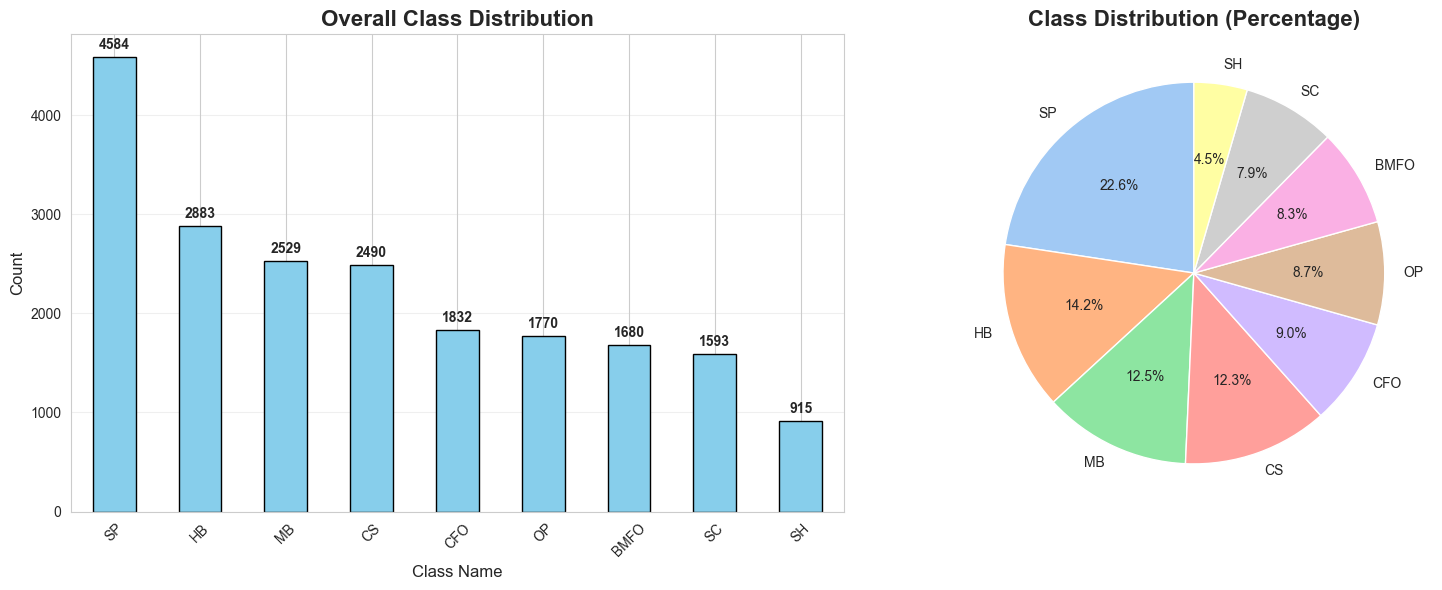

Most common class: SP (4584 samples)
Least common class: SH (915 samples)
Imbalance ratio: 5.01:1


In [86]:
# Overall class distribution
class_counts = all_annotations['class_name'].value_counts()
print("\n Overall Class Distribution:")
print(class_counts)

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall distribution - Bar chart
ax1 = axes[0]
class_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Overall Class Distribution', fontsize=16, fontweight='bold')
ax1.set_xlabel('Class Name', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_counts):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart showing percentage distribution
ax2 = axes[1]
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
ax2.set_title('Class Distribution (Percentage)', fontsize=16, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# Class imbalance analysis
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count # ratio of the number of samples in the majority class to the number of samples in the minority class
print(f"Most common class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
print(f"Least common class: {class_counts.index[-1]} ({class_counts.iloc[-1]} samples)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")


In [87]:
print("BOUNDING BOX STATISTICS")
print("="*60)

# Basic statistics
print("\nBounding Box Dimensions (normalized as they are in YOLO format):")
print("\nWidth statistics:")
print(all_annotations['bbox_width'].describe())
print("\nHeight statistics:")
print(all_annotations['bbox_height'].describe())
print("\nArea statistics:")
print(all_annotations['bbox_area'].describe())

# Objects per image
objects_per_image = all_annotations.groupby('filename').size().reset_index(name='count')
print(f"\nObjects per Image Statistics:")
print(objects_per_image['count'].describe())

BOUNDING BOX STATISTICS

Bounding Box Dimensions (normalized as they are in YOLO format):

Width statistics:
count    20276.000000
mean         0.148582
std          0.168407
min          0.008800
25%          0.057500
50%          0.092900
75%          0.177000
max          1.000000
Name: bbox_width, dtype: float64

Height statistics:
count    20276.000000
mean         0.140628
std          0.152249
min          0.008800
25%          0.053100
50%          0.088500
75%          0.177000
max          1.000000
Name: bbox_height, dtype: float64

Area statistics:
count    20276.000000
mean         0.038508
std          0.109381
min          0.000350
25%          0.003287
50%          0.008142
75%          0.029695
max          1.000000
Name: bbox_area, dtype: float64

Objects per Image Statistics:
count    10259.000000
mean         1.976411
std          1.863553
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         27.000000
Name: count, dtype:

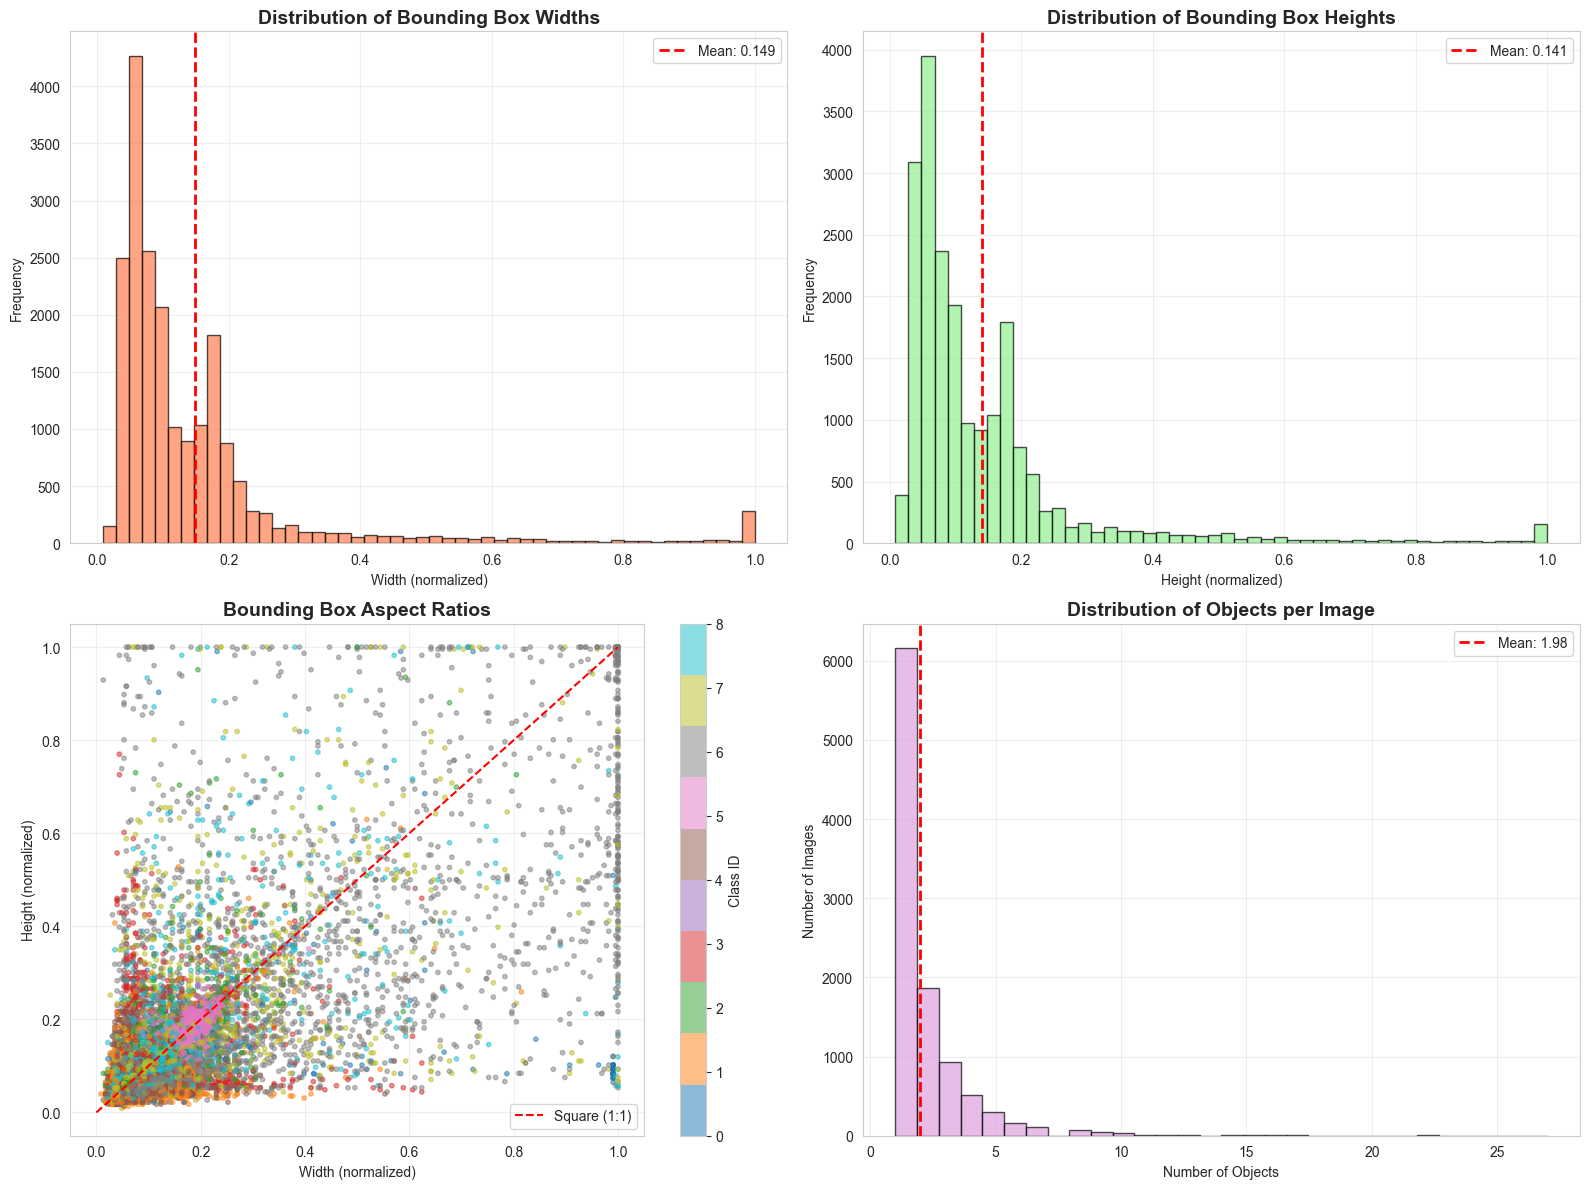


Additional Statistics:
Images with single defect: 6157
Images with multiple defects: 4102
Max defects in single image: 27


In [88]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of bbox widths
ax1 = axes[0, 0]
all_annotations['bbox_width'].hist(bins=50, ax=ax1, color='coral', edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Bounding Box Widths', fontsize=14, fontweight='bold')
ax1.set_xlabel('Width (normalized)')
ax1.set_ylabel('Frequency')
ax1.axvline(all_annotations['bbox_width'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {all_annotations['bbox_width'].mean():.3f}")
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Distribution of bbox heights
ax2 = axes[0, 1]
all_annotations['bbox_height'].hist(bins=50, ax=ax2, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Bounding Box Heights', fontsize=14, fontweight='bold')
ax2.set_xlabel('Height (normalized)')
ax2.set_ylabel('Frequency')
ax2.axvline(all_annotations['bbox_height'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {all_annotations['bbox_height'].mean():.3f}")
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Width vs Height scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(all_annotations['bbox_width'], all_annotations['bbox_height'], 
                     c=all_annotations['class_id'], cmap='tab10', alpha=0.5, s=10)
ax3.set_title('Bounding Box Aspect Ratios', fontsize=14, fontweight='bold')
ax3.set_xlabel('Width (normalized)')
ax3.set_ylabel('Height (normalized)')
ax3.plot([0, 1], [0, 1], 'r--', label='Square (1:1)')
ax3.legend()
ax3.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Class ID')

# 4. Objects per image distribution
ax4 = axes[1, 1]
objects_per_image['count'].hist(bins=30, ax=ax4, color='plum', edgecolor='black', alpha=0.7)
ax4.set_title('Distribution of Objects per Image', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Objects')
ax4.set_ylabel('Number of Images')
ax4.axvline(objects_per_image['count'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f"Mean: {objects_per_image['count'].mean():.2f}")
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print(f"\nAdditional Statistics:")
print(f"Images with single defect: {len(objects_per_image[objects_per_image['count'] == 1])}")
print(f"Images with multiple defects: {len(objects_per_image[objects_per_image['count'] > 1])}")
print(f"Max defects in single image: {objects_per_image['count'].max()}")


## Defect Size Distribution Per Class

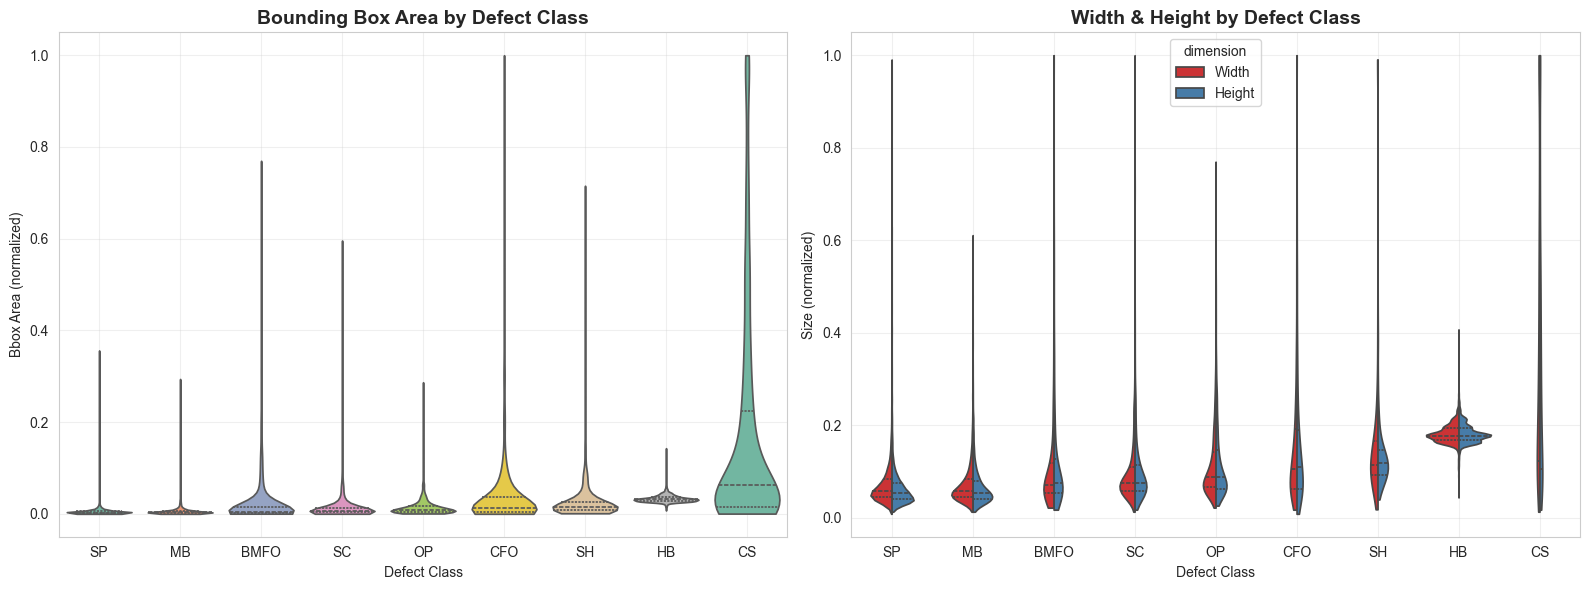

In [89]:
# Defect size (area) per class
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Violin plot of bbox area per class
order = all_annotations.groupby('class_name')['bbox_area'].median().sort_values().index
sns.violinplot(data=all_annotations, x='class_name', y='bbox_area', order=order,
               ax=axes[0], palette='Set2', cut=0, inner='quartile')
axes[0].set_title('Bounding Box Area by Defect Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Defect Class')
axes[0].set_ylabel('Bbox Area (normalized)')
axes[0].grid(alpha=0.3)

# Violin plot for width and height combined
melted = all_annotations.melt(id_vars=['class_name'], value_vars=['bbox_width', 'bbox_height'],
                              var_name='dimension', value_name='size')
melted['dimension'] = melted['dimension'].map({'bbox_width': 'Width', 'bbox_height': 'Height'})
sns.violinplot(data=melted, x='class_name', y='size', hue='dimension', order=order,
               ax=axes[1], palette='Set1', cut=0, inner='quartile', split=True)
axes[1].set_title('Width & Height by Defect Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Defect Class')
axes[1].set_ylabel('Size (normalized)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Aspect Ratio Distribution Per Class


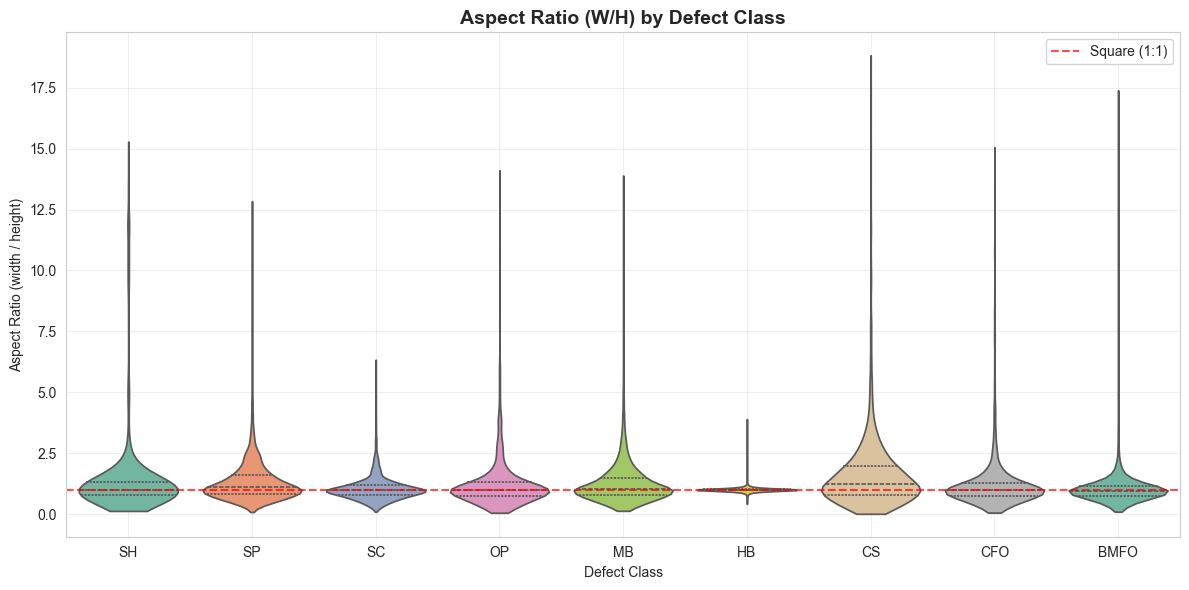

In [90]:
# Aspect ratio per class
all_annotations['aspect_ratio'] = all_annotations['bbox_width'] / all_annotations['bbox_height']

fig, ax = plt.subplots(figsize=(12, 6))
order = list(CLASS_NAMES.values())
sns.violinplot(data=all_annotations, x='class_name', y='aspect_ratio', order=order,
               palette='Set2', cut=0, inner='quartile', ax=ax)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Square (1:1)')
ax.set_title('Aspect Ratio (W/H) by Defect Class', fontsize=14, fontweight='bold')
ax.set_xlabel('Defect Class')
ax.set_ylabel('Aspect Ratio (width / height)')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

CLASS CO-OCCURRENCE ANALYSIS


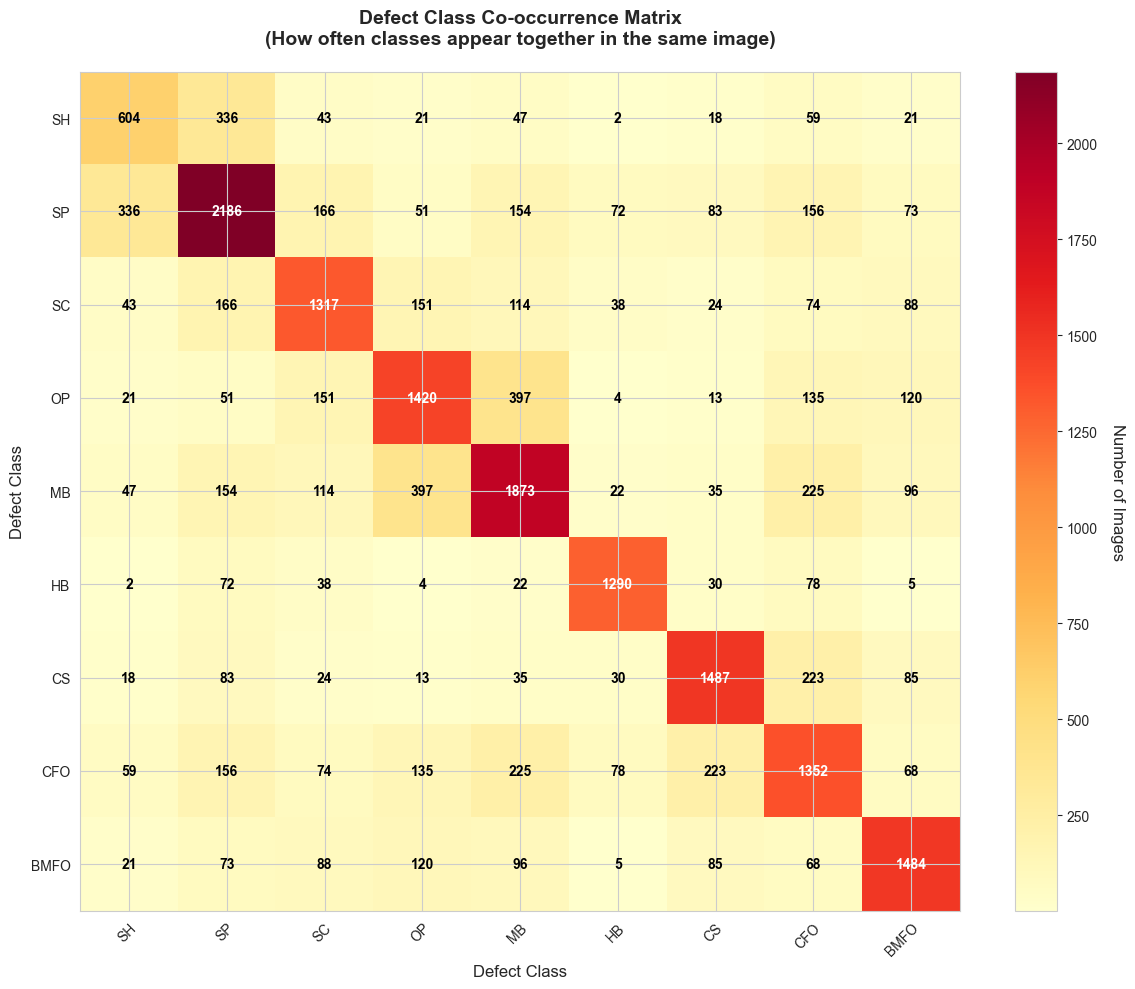

In [91]:
# Class Co-occurrence Analysis
print("CLASS CO-OCCURRENCE ANALYSIS")
print("="*60)

# Create co-occurrence matrix (9x9 for 9 classes)
n_classes = len(CLASS_NAMES)
cooccurrence_matrix = np.zeros((n_classes, n_classes), dtype=int)

# For each image, find which classes appear together
for filename in os.listdir(LABELS_DIR):
    if filename.endswith('.txt'):
        label_path = os.path.join(LABELS_DIR, filename)
        
        # Get all unique classes in this image
        classes_in_image = set()
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    classes_in_image.add(class_id)
        
        # Increment co-occurrence for all pairs (including self)
        for class_a in classes_in_image:
            for class_b in classes_in_image:
                cooccurrence_matrix[class_a, class_b] += 1

# Create visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Plot heatmap
im = ax.imshow(cooccurrence_matrix, cmap='YlOrRd', aspect='auto')

# Set ticks and labels
class_labels = [CLASS_NAMES[i] for i in range(n_classes)]
ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Rotate x labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(n_classes):
    for j in range(n_classes):
        text = ax.text(j, i, cooccurrence_matrix[i, j],
                      ha="center", va="center", color="black" if cooccurrence_matrix[i, j] < cooccurrence_matrix.max()/2 else "white",
                      fontsize=10, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of Images', rotation=270, labelpad=20, fontsize=12)

ax.set_title('Defect Class Co-occurrence Matrix\n(How often classes appear together in the same image)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Defect Class', fontsize=12)
ax.set_ylabel('Defect Class', fontsize=12)

plt.tight_layout()
plt.show()


In [92]:
print("\nMost Common Co-occurrences (excluding self):")
cooccur_list = []
for i in range(n_classes):
    for j in range(i+1, n_classes):  # Only upper triangle to avoid duplicates
        if cooccurrence_matrix[i, j] > 0:
            cooccur_list.append((CLASS_NAMES[i], CLASS_NAMES[j], cooccurrence_matrix[i, j]))

# Sort by count and print top 10
cooccur_list.sort(key=lambda x: x[2], reverse=True)
for class_a, class_b, count in cooccur_list[:10]:
    print(f"  {class_a:6s} + {class_b:6s}: {count:4d} images")


Most Common Co-occurrences (excluding self):
  OP     + MB    :  397 images
  SH     + SP    :  336 images
  MB     + CFO   :  225 images
  CS     + CFO   :  223 images
  SP     + SC    :  166 images
  SP     + CFO   :  156 images
  SP     + MB    :  154 images
  SC     + OP    :  151 images
  OP     + CFO   :  135 images
  OP     + BMFO  :  120 images


## Defect Spatial Distribution 

Where Do Defects Appear Within the Patch?

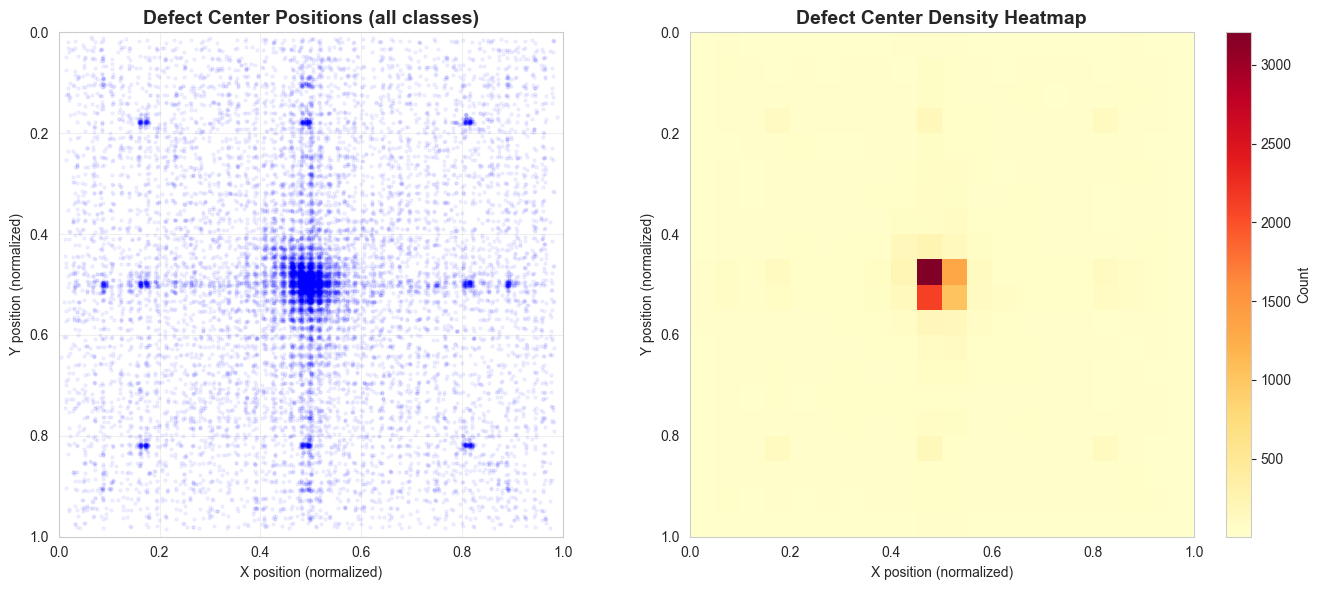

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter of all defect centers
axes[0].scatter(all_annotations['center_x'], all_annotations['center_y'],
                alpha=0.05, s=5, c='blue')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(1, 0)  # flip y to match image coords
axes[0].set_title('Defect Center Positions (all classes)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X position (normalized)')
axes[0].set_ylabel('Y position (normalized)')
axes[0].set_aspect('equal')
axes[0].grid(alpha=0.3)

# 2D histogram / heatmap
h = axes[1].hist2d(all_annotations['center_x'], all_annotations['center_y'],
                   bins=20, cmap='YlOrRd', range=[[0, 1], [0, 1]])
axes[1].set_ylim(1, 0)
axes[1].set_title('Defect Center Density Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X position (normalized)')
axes[1].set_ylabel('Y position (normalized)')
axes[1].set_aspect('equal')
plt.colorbar(h[3], ax=axes[1], label='Count')

plt.tight_layout()
plt.show()

### Brightness & Lighting Distribution Analysis
Understanding brightness distribution helps identify:
- Under/over-exposed images in the dataset
- Whether certain defect types tend to appear in regions of the PCB that received less light during the image acquisition process

This analysis is done to check the possibility of patterns in lighting conditions leading to patterns in detection models performace.

In [94]:
def calculate_image_brightness(img_path):
    """Calculate mean brightness of entire image"""
    img = cv.imread(img_path)
    if img is None:
        return None
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray.mean()

In [95]:
def calculate_defect_brightness(img_path, label_path):
    """Calculate brightness for each defect bounding box"""
    img = cv.imread(img_path)
    if img is None:
        return []
    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    h, w = gray.shape
    
    defect_data = []
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)
                    
                    # Ensure coordinates are within image bounds
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)
                    
                    # Extract crop and calculate brightness
                    if x2 > x1 and y2 > y1:
                        crop = gray[y1:y2, x1:x2]
                        brightness = crop.mean()
                        defect_data.append({
                            'class_id': class_id,
                            'brightness': brightness
                        })
    
    return defect_data

In [96]:
# Collect brightness data
print("Analyzing brightness distribution across dataset... (sanity check prints)")
image_brightnesses = []
defect_brightnesses = {class_id: [] for class_id in CLASS_NAMES.keys()}

for filename in os.listdir(IMAGES_DIR):
    if filename.endswith(('.jpg', '.png')):
        img_path = os.path.join(IMAGES_DIR, filename)
        label_path = os.path.join(LABELS_DIR, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
            
        # Image-level brightness
        brightness = calculate_image_brightness(img_path)
        if brightness is not None:
            image_brightnesses.append(brightness)
            
        # Per-defect brightness
        defects = calculate_defect_brightness(img_path, label_path)
        for defect in defects:
            defect_brightnesses[defect['class_id']].append(defect['brightness'])

print(f"Analyzed {len(image_brightnesses)} images")
print(f"Analyzed {sum(len(v) for v in defect_brightnesses.values())} defect instances")

Analyzing brightness distribution across dataset... (sanity check prints)
Analyzed 10259 images
Analyzed 20276 defect instances


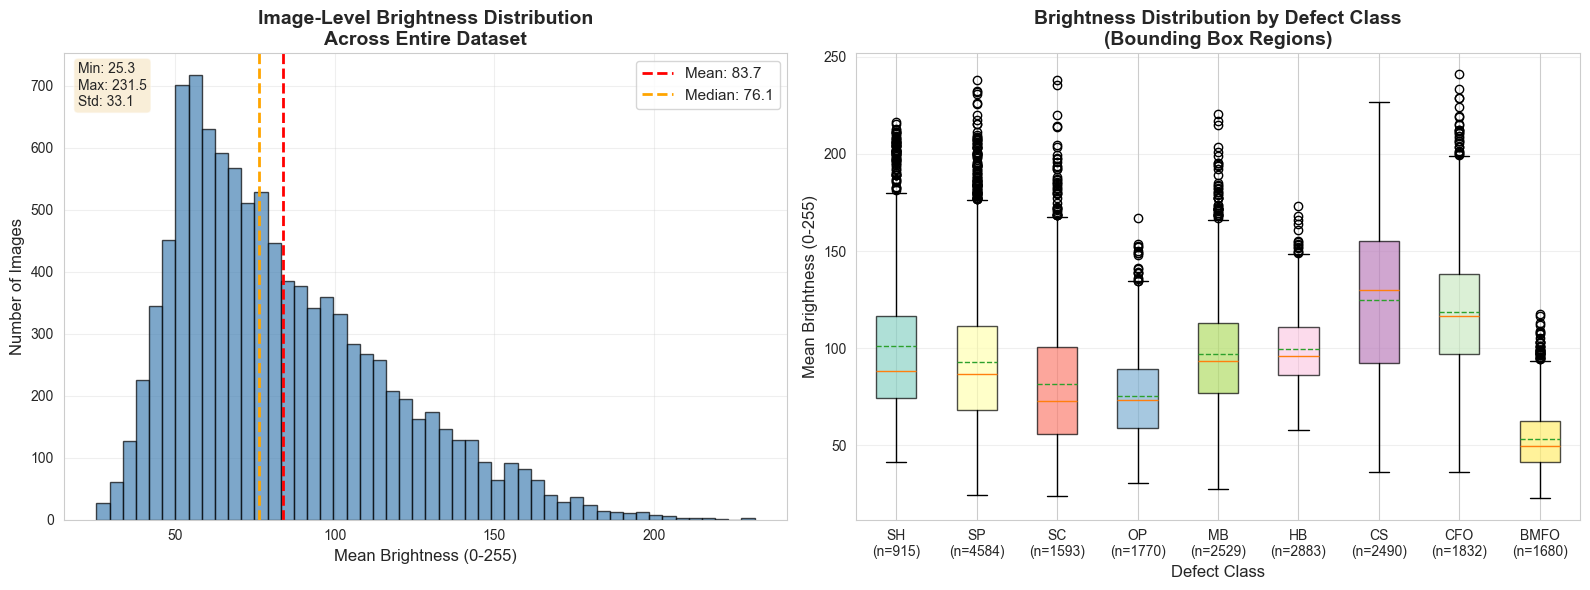

BRIGHTNESS SUMMARY STATISTICS

Image-Level Brightness:
  Mean: 83.66
  Median: 76.12
  Std Dev: 33.10
  Range: [25.29, 231.48]

Per-Defect Class Brightness:
  SH     (n=  915): Mean=100.86, Median= 88.26, Std=39.70
  SP     (n= 4584): Mean= 92.78, Median= 86.40, Std=33.86
  SC     (n= 1593): Mean= 81.71, Median= 72.55, Std=34.92
  OP     (n= 1770): Mean= 75.40, Median= 73.42, Std=21.25
  MB     (n= 2529): Mean= 96.70, Median= 93.24, Std=27.73
  HB     (n= 2883): Mean= 99.25, Median= 96.07, Std=16.91
  CS     (n= 2490): Mean=124.73, Median=129.69, Std=34.42
  CFO    (n= 1832): Mean=118.66, Median=116.57, Std=33.12
  BMFO   (n= 1680): Mean= 53.35, Median= 49.42, Std=16.14


In [97]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Image-Level Brightness Distribution
ax1 = axes[0]
ax1.hist(image_brightnesses, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(image_brightnesses), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(image_brightnesses):.1f}')
ax1.axvline(np.median(image_brightnesses), color='orange', linestyle='--', 
            linewidth=2, label=f'Median: {np.median(image_brightnesses):.1f}')
ax1.set_xlabel('Mean Brightness (0-255)', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Image-Level Brightness Distribution\nAcross Entire Dataset', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Add statistics text
stats_text = f"Min: {np.min(image_brightnesses):.1f}\nMax: {np.max(image_brightnesses):.1f}\nStd: {np.std(image_brightnesses):.1f}"
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Per-Defect Class Brightness Distribution
ax2 = axes[1]
data_for_boxplot = []
labels_for_boxplot = []

for class_id in sorted(CLASS_NAMES.keys()):
    if len(defect_brightnesses[class_id]) > 0:
        data_for_boxplot.append(defect_brightnesses[class_id])
        labels_for_boxplot.append(f"{CLASS_NAMES[class_id]}\n(n={len(defect_brightnesses[class_id])})")

bp = ax2.boxplot(data_for_boxplot, labels=labels_for_boxplot, patch_artist=True,
                  showmeans=True, meanline=True)

# Color the boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(data_for_boxplot)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Mean Brightness (0-255)', fontsize=12)
ax2.set_xlabel('Defect Class', fontsize=12)
ax2.set_title('Brightness Distribution by Defect Class\n(Bounding Box Regions)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# summary statistics
print("BRIGHTNESS SUMMARY STATISTICS")
print("\nImage-Level Brightness:")
print(f"  Mean: {np.mean(image_brightnesses):.2f}")
print(f"  Median: {np.median(image_brightnesses):.2f}")
print(f"  Std Dev: {np.std(image_brightnesses):.2f}")
print(f"  Range: [{np.min(image_brightnesses):.2f}, {np.max(image_brightnesses):.2f}]")

print("\nPer-Defect Class Brightness:")
for class_id in sorted(CLASS_NAMES.keys()):
    if len(defect_brightnesses[class_id]) > 0:
        vals = defect_brightnesses[class_id]
        print(f"  {CLASS_NAMES[class_id]:6s} (n={len(vals):5d}): "
              f"Mean={np.mean(vals):6.2f}, Median={np.median(vals):6.2f}, "
              f"Std={np.std(vals):5.2f}")
print("="*60)

In [98]:
# Summary statistics
print("BRIGHTNESS SUMMARY STATISTICS")
print("\nImage-Level Brightness:")
print(f"  Mean: {np.mean(image_brightnesses):.2f}")
print(f"  Median: {np.median(image_brightnesses):.2f}")
print(f"  Std Dev: {np.std(image_brightnesses):.2f}")
print(f"  Range: [{np.min(image_brightnesses):.2f}, {np.max(image_brightnesses):.2f}]")

print("\nPer-Defect Class Brightness:")
# Create DataFrame for nice table display
brightness_stats = []
for class_id in sorted(CLASS_NAMES.keys()):
    if len(defect_brightnesses[class_id]) > 0:
        vals = defect_brightnesses[class_id]
        brightness_stats.append({
            'Class': CLASS_NAMES[class_id],
            'Count': len(vals),
            'Mean': np.mean(vals),
            'Median': np.median(vals),
            'Std': np.std(vals),
            'Min': np.min(vals),
            'Max': np.max(vals)
        })

df_brightness = pd.DataFrame(brightness_stats)

BRIGHTNESS SUMMARY STATISTICS

Image-Level Brightness:
  Mean: 83.66
  Median: 76.12
  Std Dev: 33.10
  Range: [25.29, 231.48]

Per-Defect Class Brightness:


In [99]:
df_brightness

,Class,Count,Mean,Median,Std,Min,Max
0,SH,915,100.857373,88.255578,39.698962,41.141869,216.608187
1,SP,4584,92.779557,86.401685,33.857832,24.066667,238.142857
2,SC,1593,81.713535,72.548913,34.923853,23.790000,238.376225
3,OP,1770,75.396500,73.424644,21.246988,30.470801,167.190334
4,MB,2529,96.703076,93.242604,27.728381,27.347826,220.577778
5,HB,2883,99.246385,96.073780,16.910425,57.648171,173.440034
6,CS,2490,124.732202,129.692801,34.419199,35.960404,226.572414
7,CFO,1832,118.658590,116.573180,33.119692,35.883529,241.048834
8,BMFO,1680,53.352604,49.416836,16.143724,22.552885,117.672797


### Brightness of specific defect classes

Analyzing overall image brightness for images containing BMFO (class 8), SC (class 2), and OP (class 3) - classes that showed lower brightness in bounding box regions.

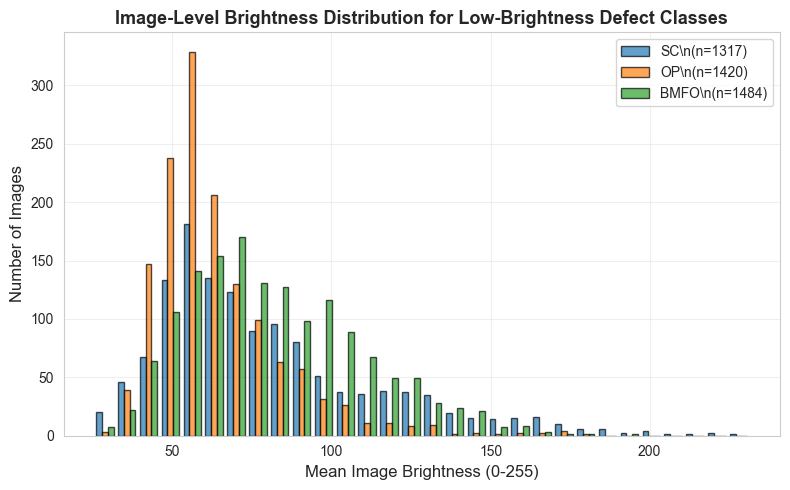

\nImage-Level Brightness Statistics:
\nSC (n=1317):
  Mean: 80.5
  Median: 70.4
  Std: 35.2
  Range: [25.9, 231.5]
\nOP (n=1420):
  Mean: 63.8
  Median: 58.6
  Std: 20.3
  Range: [30.4, 181.4]
\nBMFO (n=1484):
  Mean: 82.0
  Median: 77.5
  Std: 27.4
  Range: [25.3, 193.2]


In [100]:
# Collect image brightness grouped by defect class

target_classes = {2: 'SC', 3: 'OP', 8: 'BMFO'}  # Classes with lower brightness
class_image_brightness = defaultdict(list)

for filename in os.listdir(IMAGES_DIR):
    if filename.endswith(('.jpg', '.png')):
        img_path = os.path.join(IMAGES_DIR, filename)
        label_path = os.path.join(LABELS_DIR, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        
        # Get image brightness
        img_brightness = calculate_image_brightness(img_path)
        if img_brightness is None:
            continue
        
        # Check which target classes are in this image (only add once per image per class)
        if os.path.exists(label_path):
            classes_in_image = set()
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        if class_id in target_classes:
                            classes_in_image.add(class_id)
            
            # Add image brightness once per class present
            for cls_id in classes_in_image:
                class_image_brightness[cls_id].append(img_brightness)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

data_to_plot = [class_image_brightness[cls_id] for cls_id in sorted(target_classes.keys())]
labels = [f"{target_classes[cls_id]}\\n(n={len(class_image_brightness[cls_id])})" 
          for cls_id in sorted(target_classes.keys())]

ax.hist(data_to_plot, bins=30, label=labels, alpha=0.7, edgecolor='black')
ax.set_xlabel('Mean Image Brightness (0-255)', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Image-Level Brightness Distribution for Low-Brightness Defect Classes', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Summary stats
print("\\nImage-Level Brightness Statistics:")
for cls_id in sorted(target_classes.keys()):
    brightness_vals = class_image_brightness[cls_id]
    print(f"\\n{target_classes[cls_id]} (n={len(brightness_vals)}):")
    print(f"  Mean: {np.mean(brightness_vals):.1f}")
    print(f"  Median: {np.median(brightness_vals):.1f}")
    print(f"  Std: {np.std(brightness_vals):.1f}")
    print(f"  Range: [{np.min(brightness_vals):.1f}, {np.max(brightness_vals):.1f}]")